In [1]:
import re
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt

# Report Text Data

In [2]:
# list of two-character US state (and DC) codes
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [3]:
report_df = pd.read_csv('data/report_scrape/report_text.csv')
report_df.set_index('report_id', inplace=True)
# drop post_date column
report_df.drop('post_date')
report_df.head()

,datetime,city,state,shape,duration,post_date,report_text
report_id,,,,,,,
144/S144369,12/31/18 23:30,San Antonio,TX,Sphere,15 minutes,1/11/19,I saw fiery orange lights no sound flying at l...
144/S144243,12/31/18 21:41,Ormond Beach,FL,Fireball,20 seconds,1/4/19,"Orange glowing object racing though the sky.,A..."
144/S144260,12/31/18 21:45,Kiawah Island,SC,Sphere,10 seconds,1/4/19,"On New Year’s Eve night on Kiawah Island, I ca..."
144/S144245,12/31/18 21:47,Brandon,MS,Unknown,5 minutes,1/4/19,"2 strange formations of continuous red-orange,..."
144/S144558,12/31/18 22:00,Spring,TX,NaN,~15 minutes,1/24/19,"Red/ Orange lights - spherical shape,Location:..."


In [4]:
len(report_df)

63850

In [19]:
ufo_df = report_df.copy()

In [38]:
len(ufo_df)

48097

## location 
US locations only

https://simplemaps.com/data/us-cities

In [21]:
# missing city locations
ufo_df['city'].isna().sum()

100

In [22]:
# drop records without city location
ufo_df.dropna(subset=['city'], inplace=True)

In [23]:
# add geolocation
ufo_df['geolocation'] = ufo_df['city'] + ', ' + ufo_df['state']

In [24]:
# total non-US locations
(~ufo_df['state'].isin(states)).sum()

4989

In [25]:
# filter out non-US locaions
ufo_df = ufo_df[ufo_df['state'].isin(states)]

In [26]:
# read in city coordinates dataframe
geo_cities = pd.read_csv('data/simplemaps_uscities_basicv1.6/uscities.csv', 
                         usecols=['city', 'state_id', 'lat', 'lng'])
geo_cities.head()

,city,state_id,lat,lng
0,South Creek,WA,46.9994,-122.3921
1,Roslyn,WA,47.2507,-121.0989
2,Sprague,WA,47.3048,-117.9713
3,Gig Harbor,WA,47.3352,-122.5968
4,Lake Cassidy,WA,48.0639,-122.0920


In [33]:
# list of cities
geo_locs = geo_cities['city'] + ', ' + geo_cities['state_id']

In [37]:
# filter cities
ufo_df = ufo_df[ufo_df['geolocation'].isin(geo_locs)]

In [40]:
ufo_df.head()

,datetime,city,state,shape,duration,post_date,report_text,geolocation
report_id,,,,,,,,
144/S144369,12/31/18 23:30,San Antonio,TX,Sphere,15 minutes,1/11/19,I saw fiery orange lights no sound flying at l...,"San Antonio, TX"
144/S144243,12/31/18 21:41,Ormond Beach,FL,Fireball,20 seconds,1/4/19,"Orange glowing object racing though the sky.,A...","Ormond Beach, FL"
144/S144260,12/31/18 21:45,Kiawah Island,SC,Sphere,10 seconds,1/4/19,"On New Year’s Eve night on Kiawah Island, I ca...","Kiawah Island, SC"
144/S144245,12/31/18 21:47,Brandon,MS,Unknown,5 minutes,1/4/19,"2 strange formations of continuous red-orange,...","Brandon, MS"
144/S144558,12/31/18 22:00,Spring,TX,NaN,~15 minutes,1/24/19,"Red/ Orange lights - spherical shape,Location:...","Spring, TX"


In [43]:
# combine data with location coordinates
mrg_df = pd.merge(ufo_df, geo_cities, left_on=['city', 'state'], right_on=['city', 'state_id'])
mrg_df.head()

,datetime,city,state,shape,duration,post_date,report_text,geolocation,state_id,lat,lng
0,12/31/18 23:30,San Antonio,TX,Sphere,15 minutes,1/11/19,I saw fiery orange lights no sound flying at l...,"San Antonio, TX",TX,29.4658,-98.5254
1,2/14/18 20:00,San Antonio,TX,Oval,25 minutes,2/22/18,spacecraft seen by two people over power lines...,"San Antonio, TX",TX,29.4658,-98.5254
2,3/10/18 23:15,San Antonio,TX,Sphere,45 seconds,3/23/18,"Orange Sphere Travels From East to West,Bright...","San Antonio, TX",TX,29.4658,-98.5254
3,5/5/18 11:30,San Antonio,TX,Formation,2-5 minutes,5/10/18,20-25 metallic triangular objects spotted on C...,"San Antonio, TX",TX,29.4658,-98.5254
4,11/2/18 10:00,San Antonio,TX,Rectangle,5 seconds,11/9/18,Strange Light Over San Antonio (Fresno St/Edis...,"San Antonio, TX",TX,29.4658,-98.5254


In [44]:
# group by cities
city_df = mrg_df.groupby(by=['lat', 'lng']).count()
city_df.head()

,,datetime,city,state,shape,duration,post_date,report_text,geolocation,state_id
lat,lng,,,,,,,,,
19.0698,-155.5751,1,1,1,1,1,1,1,1,1
19.5286,-155.9033,1,1,1,1,1,1,1,1,1
19.5358,-155.1596,1,1,1,1,1,1,1,1,1
19.5833,-155.0721,1,1,1,1,1,1,1,1,1
19.6156,-155.0372,5,5,5,4,5,5,5,5,5


In [58]:
import folium
from folium.plugins import HeatMap

In [56]:
lats = city_df.index.get_level_values('lat')
longs = city_df.index.get_level_values('lng')
num_site = city_df['geolocation']
max_num = city_df['geolocation'].max()

In [46]:
hmap = folium.Map()

In [59]:
hm_wide = HeatMap( list(zip(lats, longs, num_site)),
                   min_opacity=0.2,
                   max_val=max_num,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )

In [60]:
hmap.add_child(hm_wide)

## report text

In [7]:
# reports missing text
ufo_df['report_text'].isna().sum()

34

In [8]:
# drop reports missing text
ufo_df.dropna(subset=['report_text'], inplace=True)

In [9]:
# remove ((NUFORC Note: ... PD))


## shape
fill NaNs with "Unknown"

In [16]:
# missing shape
ufo_df['shape'].isna().sum()

1140

In [17]:
# shape types
ufo_df['shape'].unique()

array(['Sphere', 'Fireball', 'Unknown', nan, 'Light', 'Egg', 'Flash',
       'Cigar', 'Circle', 'Diamond', 'Triangle', 'Oval', 'Cylinder',
       'Changing', 'Formation', 'Other', 'Disk', 'Cross', 'Cone',
       'Rectangle', 'Chevron', 'Teardrop'], dtype=object)

In [18]:
# replace nans with uknown
ufo_df['shape'] = ufo_df['shape'].replace(float('NaN'), 'Unknown')

## datetime format
reformat datetime data to single standard

In [19]:
ufo_df['datetime'].isna().sum()

0

In [20]:
# datetime formats
ufo_df['datetime'].apply(lambda x: re.sub('\d', 'X', x)).unique()

array(['XX/XX/XX XX:XX', 'XX/X/XX XX:XX', 'X/XX/XX XX:XX', 'X/X/XX XX:XX',
       'X/X/XX', 'X/XX/XX', 'XX/XX/XX', 'XX/X/XX'], dtype=object)

In [21]:
# datetime split functions
def return_time(date_time):
    try:
        return(date_time.split(' ')[1])
    except:
        return(None)
    
def return_date(date_time):
    try:
        return(date_time.split(' ')[0])
    except:
        return(None)

In [22]:
ufo_df['date'] = ufo_df['datetime'].apply(lambda x: return_date(x))
ufo_df['time'] = ufo_df['datetime'].apply(lambda x: return_time(x))

In [23]:
ufo_df.head()

,datetime,city,state,shape,duration,post_date,report_text,geolocation,date,time
report_id,,,,,,,,,,
144/S144369,12/31/18 23:30,San Antonio,TX,Sphere,15 minutes,1/11/19,I saw fiery orange lights no sound flying at l...,"San Antonio, TX",12/31/18,23:30
144/S144243,12/31/18 21:41,Ormond Beach,FL,Fireball,20 seconds,1/4/19,"Orange glowing object racing though the sky.,A...","Ormond Beach, FL",12/31/18,21:41
144/S144260,12/31/18 21:45,Kiawah Island,SC,Sphere,10 seconds,1/4/19,"On New Year’s Eve night on Kiawah Island, I ca...","Kiawah Island, SC",12/31/18,21:45
144/S144245,12/31/18 21:47,Brandon,MS,Unknown,5 minutes,1/4/19,"2 strange formations of continuous red-orange,...","Brandon, MS",12/31/18,21:47
144/S144558,12/31/18 22:00,Spring,TX,Unknown,~15 minutes,1/24/19,"Red/ Orange lights - spherical shape,Location:...","Spring, TX",12/31/18,22:00


## duration format
convert all duration to seconds

In [24]:
# missing duration
ufo_df['duration'].isna().sum()

1546

In [25]:
durs = ufo_df['duration'].dropna()

In [26]:
# duration formats
durs.apply(lambda x: re.sub('\d', 'X', x)).nunique()

2594

In [ ]:
# fill nans with average duration

## drop columns

In [ ]:
ufo_df.drop(columns=['datetime', 'city', 'state', 'post_date'], inplace=True)

# Scrape List
Select report month records to be scraped

In [2]:
month_df = pd.read_csv('data/report_counts.csv', header=0, index_col=0)
month_df.rename(columns={'Reports': 'Month'}, inplace=True)
month_df.head()

,Month,Count,Link
0,09/2019,257,http://www.nuforc.org/webreports/ndxe201909.html
1,08/2019,442,http://www.nuforc.org/webreports/ndxe201908.html
2,07/2019,582,http://www.nuforc.org/webreports/ndxe201907.html
3,06/2019,463,http://www.nuforc.org/webreports/ndxe201906.html
4,05/2019,526,http://www.nuforc.org/webreports/ndxe201905.html


In [3]:
# remove unspecified reports
month_df.drop(index=[944], inplace=True)

In [4]:
# list records after 1945
check_45 = month_df['Month'].apply(lambda x: int(x.split('/')[1]) > 1945)

In [5]:
# filter df
month_df = month_df[check_45]
month_df.tail()

,Month,Count,Link
847,06/1946,4,http://www.nuforc.org/webreports/ndxe194606.html
848,05/1946,1,http://www.nuforc.org/webreports/ndxe194605.html
849,03/1946,1,http://www.nuforc.org/webreports/ndxe194603.html
850,02/1946,1,http://www.nuforc.org/webreports/ndxe194602.html
851,01/1946,1,http://www.nuforc.org/webreports/ndxe194601.html


In [6]:
# save to csv file
# month_df.to_csv('data/report_months.csv')

In [7]:
# read back csv file
# pd.read_csv('data/report_months.csv', index_col=0).head()

,Month,Count,Link
0,09/2019,257,http://www.nuforc.org/webreports/ndxe201909.html
1,08/2019,442,http://www.nuforc.org/webreports/ndxe201908.html
2,07/2019,582,http://www.nuforc.org/webreports/ndxe201907.html
3,06/2019,463,http://www.nuforc.org/webreports/ndxe201906.html
4,05/2019,526,http://www.nuforc.org/webreports/ndxe201905.html


# Report Overview Data

In [51]:
counts_df = pd.read_csv('data/report_counts.csv', index_col=0)
# drop last row
counts_df.drop(counts_df.tail(1).index,inplace=True)
counts_df.head()

,Reports,Count,Link
0,09/2019,257,http://www.nuforc.org/webreports/ndxe201909.html
1,08/2019,442,http://www.nuforc.org/webreports/ndxe201908.html
2,07/2019,582,http://www.nuforc.org/webreports/ndxe201907.html
3,06/2019,463,http://www.nuforc.org/webreports/ndxe201906.html
4,05/2019,526,http://www.nuforc.org/webreports/ndxe201905.html


In [56]:
# only records from 1900 onward
counts_df = counts_df[counts_df['Reports'].str[-4:].astype('int') >= 1900]

In [58]:
# convert to datetime
counts_df['Reports'] = pd.to_datetime(counts_df['Reports'])
counts_df.head()

,Reports,Count,Link
0,2019-09-01,257,http://www.nuforc.org/webreports/ndxe201909.html
1,2019-08-01,442,http://www.nuforc.org/webreports/ndxe201908.html
2,2019-07-01,582,http://www.nuforc.org/webreports/ndxe201907.html
3,2019-06-01,463,http://www.nuforc.org/webreports/ndxe201906.html
4,2019-05-01,526,http://www.nuforc.org/webreports/ndxe201905.html


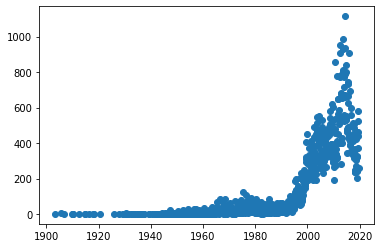

In [64]:
register_matplotlib_converters()
plt.scatter(counts_df['Reports'], counts_df['Count'])

In [82]:
# groupby month
month_counts = counts_df.groupby(by=counts_df['Reports'].dt.month).sum()
month_counts

,Count
Reports,
1,8430
2,6943
3,7962
4,8115
5,8549
6,12526
7,14797
8,13015
9,11736


In [84]:
month_counts/month_counts.sum()*100

,Count
Reports,
1,6.923172
2,5.701967
3,6.538825
4,6.664477
5,7.020901
6,10.287028
7,12.152096
8,10.688622
9,9.638238


In [74]:
season_dict = {
    1: 'winter',
    2: 'winter',
    3: 'winter',
    4: 'spring',
    5: 'spring',
    6: 'spring',
    7: 'summer',
    8: 'summer',
    9: 'summer',
    10: 'fall',
    11: 'fall',
    12: 'fall'
}

In [85]:
month_counts.set_index(month_counts.index.map(season_dict), inplace=True)

In [89]:
season_counts = month_counts.groupby(by=month_counts.index).sum()
season_counts

,Count
Reports,
fall,29692
spring,29190
summer,39548
winter,23335


In [90]:
season_counts/season_counts.sum()*100

,Count
Reports,
fall,24.384675
spring,23.972406
summer,32.478955
winter,19.163963


# Report Text Data

In [3]:
# list of two-character state codes (and DC)
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [2]:
report_df = pd.read_csv('data/report_scrape/report_text.csv')
report_df.set_index('report_id', inplace=True)
report_df.head()

,datetime,city,state,shape,duration,post_date,report_text
report_id,,,,,,,
144/S144369,12/31/18 23:30,San Antonio,TX,Sphere,15 minutes,1/11/19,I saw fiery orange lights no sound flying at l...
144/S144243,12/31/18 21:41,Ormond Beach,FL,Fireball,20 seconds,1/4/19,"Orange glowing object racing though the sky.,A..."
144/S144260,12/31/18 21:45,Kiawah Island,SC,Sphere,10 seconds,1/4/19,"On New Year’s Eve night on Kiawah Island, I ca..."
144/S144245,12/31/18 21:47,Brandon,MS,Unknown,5 minutes,1/4/19,"2 strange formations of continuous red-orange,..."
144/S144558,12/31/18 22:00,Spring,TX,NaN,~15 minutes,1/24/19,"Red/ Orange lights - spherical shape,Location:..."


In [21]:
report_df.loc['079/S79455', 'report_text']

'Poipu beach, Kauai, Hawaii New Years sighting of two firelike objects in the sky.,My spouse and I were watching the Poipu fireworks and we both noticed that there were two "sparks" that were holding still in the sky.  Initially, we both assumed that it was possible firework debris but (1) they were not falling (2) continued to burn and (3) started to move after "hovering" for >30 seconds.  We ignored the fireworks as we continued to follow these two objects begin to move and then they quickly began to move into the distance.  I wondered if perhaps someone was in a helicopter watching the firework display from above, but the light was "fire-like" and flickering -- plus the way they moved was inconsistent with any obvious explanation.  I wonder if anyone was taping the firework display, we did not have our cameras and we are stumped on how to explain what we saw.  I know the Navy maintains the Pacific missile testing range here -- but I cannot think that what was seen is congruent with 

In [23]:
report_df.iloc[15, 6]

'Bright Stars thats looks like planet but moves quicky like drone,Hi, I do not know what I saw last feb 26 at night in our bedroom in second floor.  I went to my bedroom to get something and i visited my plant which is a just right beside by the window.  I looked by the window tried to check how much is the layer of ice in my neighbors roof  anyhow i looked up the sky I saw these bright object stagnant in the sky I was kinda shocked I was thinking it may be one of the planets its sparkling to much that I called my husband to ask if what planet might it be.  then i noticed its not 1 but 5 of them scatterred but not so much you can all of them in my window them 1 star moved horinzontally i was shocked i thought it was faked and thought i might have seen a drone instead my husband said yeah it may be a drone but we think it almost up in the sky for so long and we dont know if its really capable to stand for so long. anyhow I tried to look and search any sightings here in Ottawa through in

In [41]:
for i in range(0, len(report_df), 1000):
    print(i, ':')
    print(report_df.iloc[i, 6])

0 :
I saw fiery orange lights no sound flying at low altitude no noise they moved south then flanked back but they all flanked at the same area  as they flew higher I took pictures and video  I tried to close up to see if they were lanterns but there was no flickering I have seen them before, but can’t identify them.
1000 :
Two cylindrical golden objects moving slowly far above wind turbines IOWA,On the night of August 6, 2018, around 830 pm, I was driving on a remote highway of northwest Iowa .  I just happened to glance up into the twilight sky ( sun had just set) and was stunned to see a golden cylindrical object slowly flying far up in the sky right between two wind turbines  At first I dismissed it thinking it was an airplane, but it was distinctly different. A golden glow and moving very slowly.  I looked around the sky wondering if it’s a reflection of the setting sun, but it had completely set and there were no other clouds or anything at that level but clear sky.  There were l